# Analyze the recorded performances in one notebook

In [1]:
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the TransformerLens code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")

import os
import torch
import numpy as np
import einops
import tqdm.notebook as tqdm
from datasets import load_dataset, load_from_disk
from transformers import LlamaModel, LlamaForCausalLM, LlamaTokenizer
import copy
# from utils.probing_utils import ModelActs

# from utils.analytics_utils import plot_probe_accuracies, plot_norm_diffs, plot_cosine_sims

from tqdm.notebook import tqdm
from concept_erasure import LeaceEraser
import pickle
import matplotlib.pyplot as plt
import pickle

d_model = 5120
n_layers = 40

/tmp/ipykernel_5110/2102097834.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_5110/2102097834.py:6: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [2]:
def scale_performance_relative(performances, tuple_index=None, eps=1e-10):
    """
    Scale performances to True/False probabilities by sum of True/False probabilities, to get measure of relative accuracy. Does in place.
    """
    if tuple_index is None:
        for dir_name in performances.keys():
            for layer in range(n_layers):
                for i in range(len(performances[dir_name]["True"][layer])):
                    total_prob = performances[dir_name]["True"][layer][i] + performances[dir_name]["False"][layer][i]
                    performances[dir_name]["True"][layer][i] /= (total_prob + eps)
                    performances[dir_name]["False"][layer][i] /= (total_prob + eps)

                    performances[dir_name]["Correct"][layer][i] /= (total_prob + eps)
                    performances[dir_name]["Incorrect"][layer][i] /= (total_prob + eps)
    else:
        for dir_name in performances.keys():
            for layer in range(n_layers):
                for i in range(len(performances[dir_name][tuple_index]["True"][layer])):
                    total_prob = performances[dir_name][tuple_index]["True"][layer][i] + performances[dir_name][tuple_index]["False"][layer][i]
                    performances[dir_name][tuple_index]["True"][layer][i] /= (total_prob + eps)
                    performances[dir_name][tuple_index]["False"][layer][i] /= (total_prob + eps)

                    performances[dir_name][tuple_index]["Correct"][layer][i] /= (total_prob + eps)
                    performances[dir_name][tuple_index]["Incorrect"][layer][i] /= (total_prob + eps)

In [3]:
def get_base_rate(performance, tuple_index=0, scale_relative=False):
    if tuple_index is not None:
        performance = performance[tuple_index]
    if scale_relative:    
        return (np.array([x for x in performance["Correct"].values()]) / (np.array([x for x in performance["Correct"].values()]) + np.array([x for x in performance["Incorrect"].values()]))).mean()
    else:
        return (np.array([x for x in performance["Correct"].values()])).mean()

In [4]:
## More code to plot a series of intervention patch_probs
def plot_performances(performances, plot_keys, tuple_index=None, title=None, ahxlines=None, dir_names=None, show_base_rate=False, scale_baseline_relative=False):
    """
    Plot 

    performances: dict with keys name of 
    plot_keys: list of keys to plot, e.g. ["Correct", "Incorrect"] or ["True", "False"]

    if tuple_index is not None, then performances[dir_name] is a tuple, so access at tuple_index.

    if ahxlines is not None, then plot horizontal lines at the values in ahxlines, with keys as label

    if dir_names is not None, only plot those dir names
    """
    plt.figure(figsize=(12, 8))
    
    linestyles = ['-', '--', '-.', ':']
    markers = ['s', 'o', '^', 'D']
    dir_colors = plt.cm.jet(np.linspace(0, 1, len(dir_names)))
    
    if dir_names is None:
        dir_names = performances.keys()
    for dir_name in dir_names:
        for key_idx, plot_key in enumerate(plot_keys):
            
            if tuple_index is not None:
                probs = performances[dir_name][tuple_index][plot_key]
            else:
                probs = performances[dir_name][plot_key]

            mean_probs = np.array([list(probs[layer].values()) for layer in range(n_layers)]).mean(axis=1)

            # if key_idx == 0:
            plt.plot(range(n_layers), mean_probs, marker='s', linestyle='-', label=f"{dir_name}, {plot_key}")
            
    if show_base_rate:
        base_rate = get_base_rate(performances[dir_name], 0, scale_baseline_relative)
        plt.axhline(y=base_rate, color='k', linestyle='--', label=f'Baseline')

    if ahxlines is not None:
        for ahxline in ahxlines:
            plt.axhline(y=ahxlines[ahxline], color='r', linestyle='--', label=f'{ahxline}')

    plt.xlabel('Layer')
    plt.ylabel(f'Average Probability of {plot_key}')
    plt.legend(loc="center left")
    if title is None:
        plt.title("Average Probability of Answers After Patching")
    else:
        plt.title(title)
    plt.show()

## Part 2: Interventions

In [18]:
alpha = 1
use_leace_diff_norm = True
scale_relative = False
split_name = "neg_companies"
with open(f"performances/causal_intervention_performances_{split_name=}_{alpha=}_{use_leace_diff_norm=}_{scale_relative=}.pkl", "rb") as f:
    added_performances, subtracted_performances, flipped_label_performances, flipped_dot_performances = pickle.load(f)

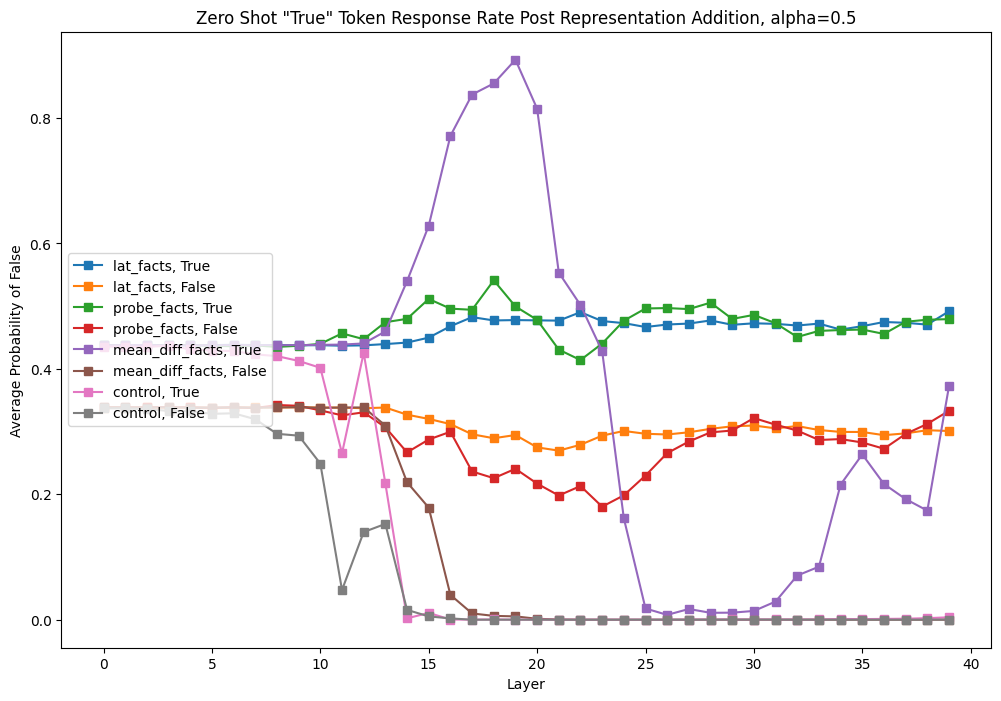

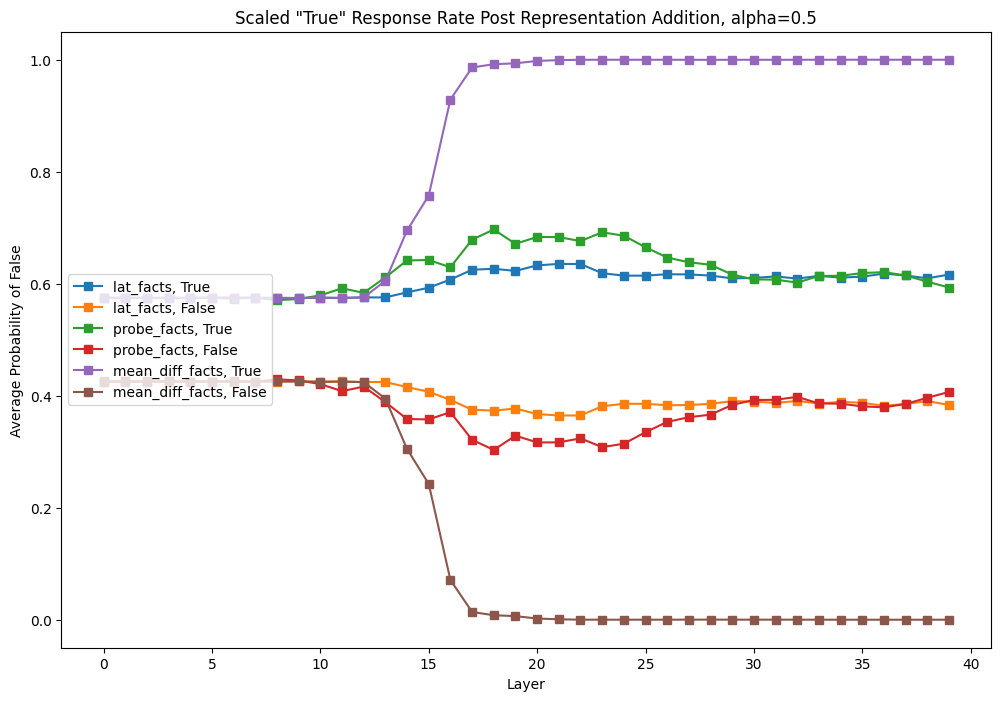

In [16]:
plot_performances(added_performances, ["True", "False"], tuple_index=1, title=f"Zero Shot \"True\" Token Response Rate Post Representation Addition, {alpha=}", scale_baseline_relative=scale_relative, dir_names=["lat_facts", "probe_facts", "mean_diff_facts", "control"])

scale_performance_relative(added_performances, tuple_index=1)
plot_performances(added_performances, ["True", "False"], tuple_index=1, title=f"Scaled \"True\" Response Rate Post Representation Addition, {alpha=}", scale_baseline_relative=scale_relative, dir_names=["lat_facts", "probe_facts", "mean_diff_facts"])

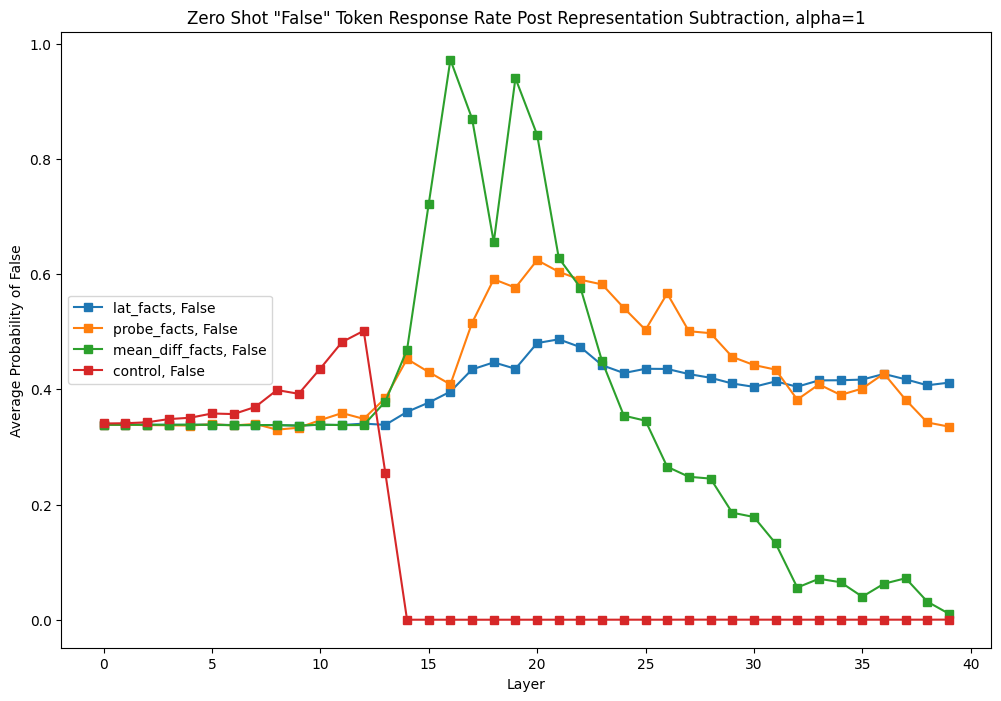

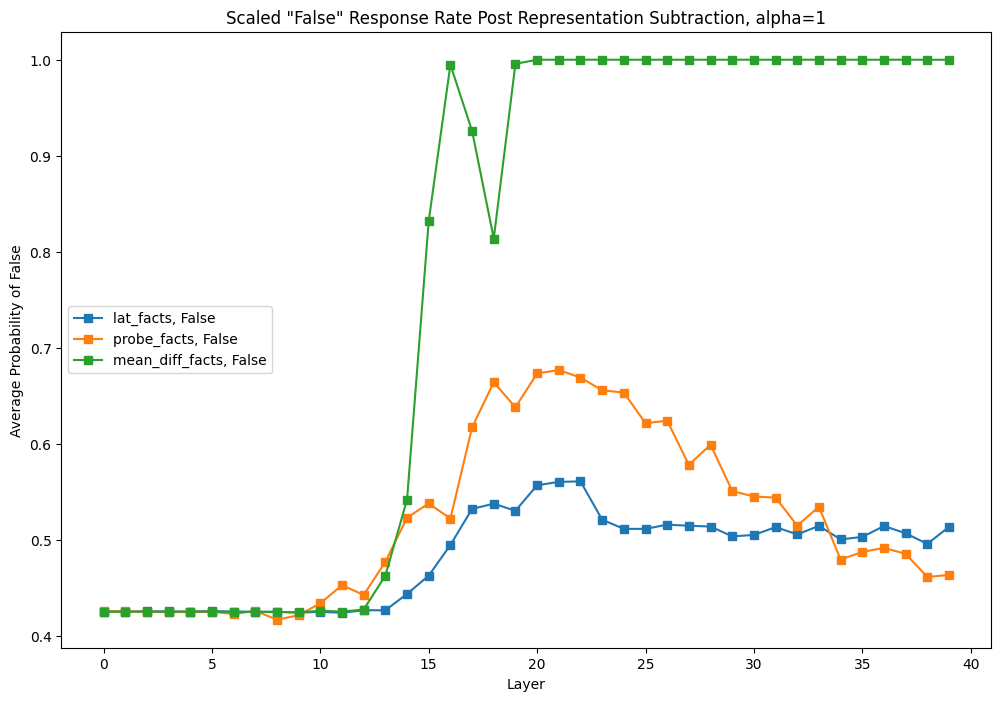

In [19]:
plot_performances(subtracted_performances, ["False"], tuple_index=1, title=f"Zero Shot \"False\" Token Response Rate Post Representation Subtraction, {alpha=}", scale_baseline_relative=scale_relative, dir_names=["lat_facts", "probe_facts", "mean_diff_facts", "control"])

scale_performance_relative(subtracted_performances, tuple_index=1)
plot_performances(subtracted_performances, ["False"], tuple_index=1, title=f"Scaled \"False\" Response Rate Post Representation Subtraction, {alpha=}", scale_baseline_relative=scale_relative, dir_names=["lat_facts", "probe_facts", "mean_diff_facts"])

In [ ]:
# scale_performance_relative(subtracted_performances, tuple_index=1)
plot_performances(subtracted_performances, ["True", "False"], tuple_index=1, title="Zero Shot \"True\" Response Rate Post Representation Subtraction")

scale_performance_relative(flipped_label_performances, tuple_index=1)
plot_performances(flipped_label_performances, ["Correct", "Incorrect"], tuple_index=1, title="Zero Shot Accuracy Post Representation Flipping with Labels")

# scale_performance_relative(flipped_dot_performances, tuple_index=1)
plot_performances(flipped_dot_performances, ["Correct", "Incorrect"], tuple_index=1, title="Zero Shot Accuracy Post Representation Flipping without Labels")

## Part 3: Removal

In [24]:
split_name = "neg_companies"
with open(f"performances/removed_performances_{split_name=}.pkl", "rb") as f:
    removed_performances = pickle.load(f)

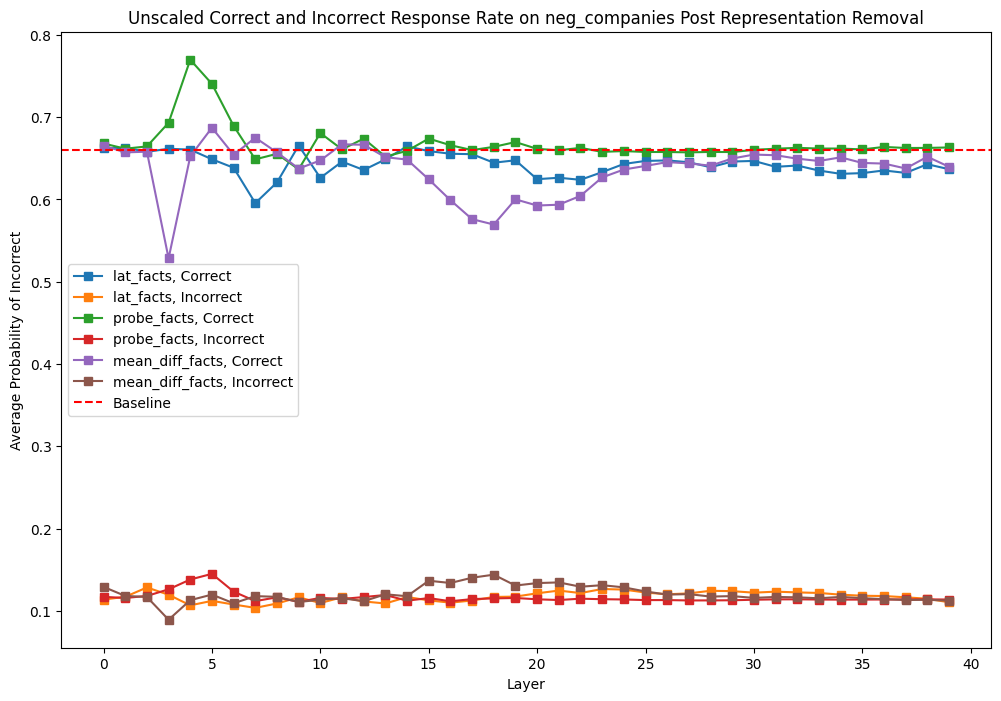

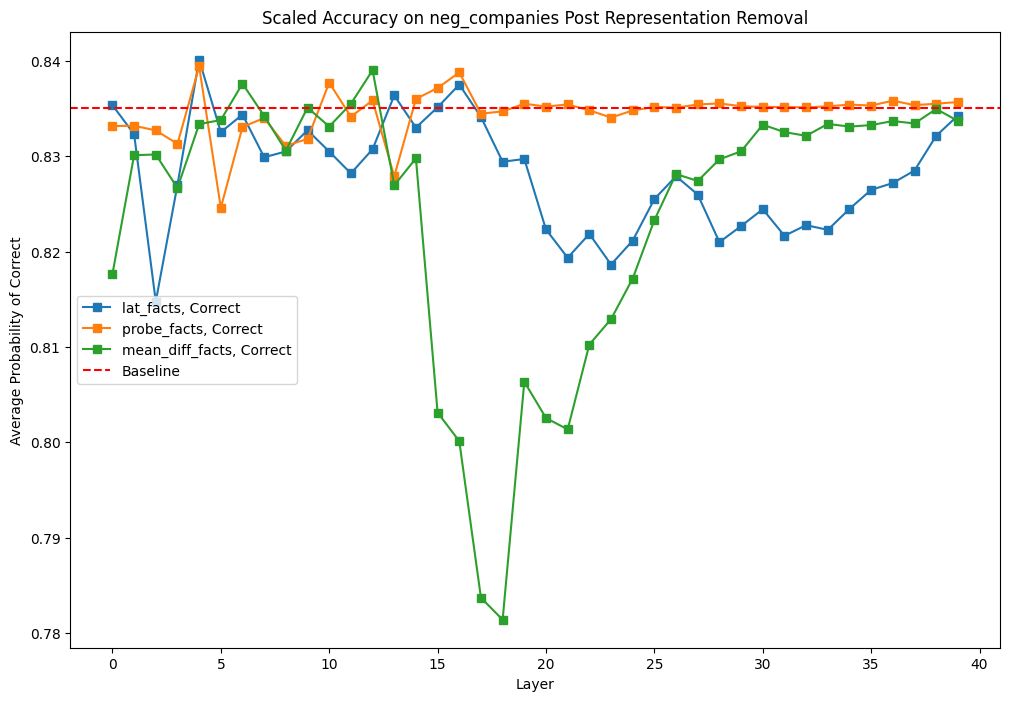

In [25]:
baseline = np.array([x for x in removed_performances["control"]["Correct"][0].values()]).mean()
plot_performances(removed_performances, ["Correct", "Incorrect"], title=f"Unscaled Correct and Incorrect Response Rate on {split_name} Post Representation Removal", ahxlines={"Baseline": baseline}, dir_names=["lat_facts", "probe_facts", "mean_diff_facts"])

scale_performance_relative(removed_performances)
# baseline = np.array([x for x in removed_performances["lat_facts"]["Correct"][0].values()]).mean() / (np.array([x for x in removed_performances["lat_facts"]["Correct"][0].values()] + np.array([x for x in removed_performances["lat_facts"]["Incorrect"][0].values()])).mean()+1e-10)
baseline = np.array([x for x in removed_performances["control"]["Correct"][0].values()]).mean()
plot_performances(removed_performances, ["Correct"], title=f"Scaled Accuracy on {split_name} Post Representation Removal", ahxlines={"Baseline": baseline}, dir_names=["lat_facts", "probe_facts", "mean_diff_facts"])


## Part 4: Recovery

In [29]:
split_name = "neg_companies"
alpha = 2
use_test = False
flip = "label" # none if never flip, label is use label to flip, dot is use dot product to flip

with open(f"performances/restored_performances_{split_name=}_{alpha=}_{flip=}_{use_test=}.pkl", "rb") as f:
    restored_performances = pickle.load(f)

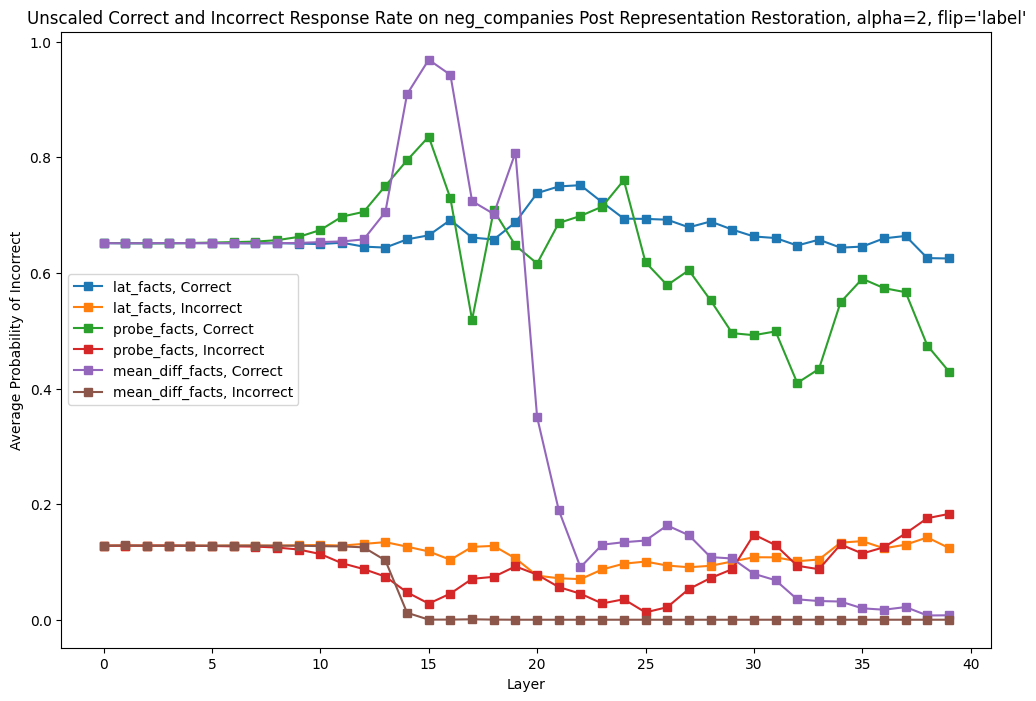

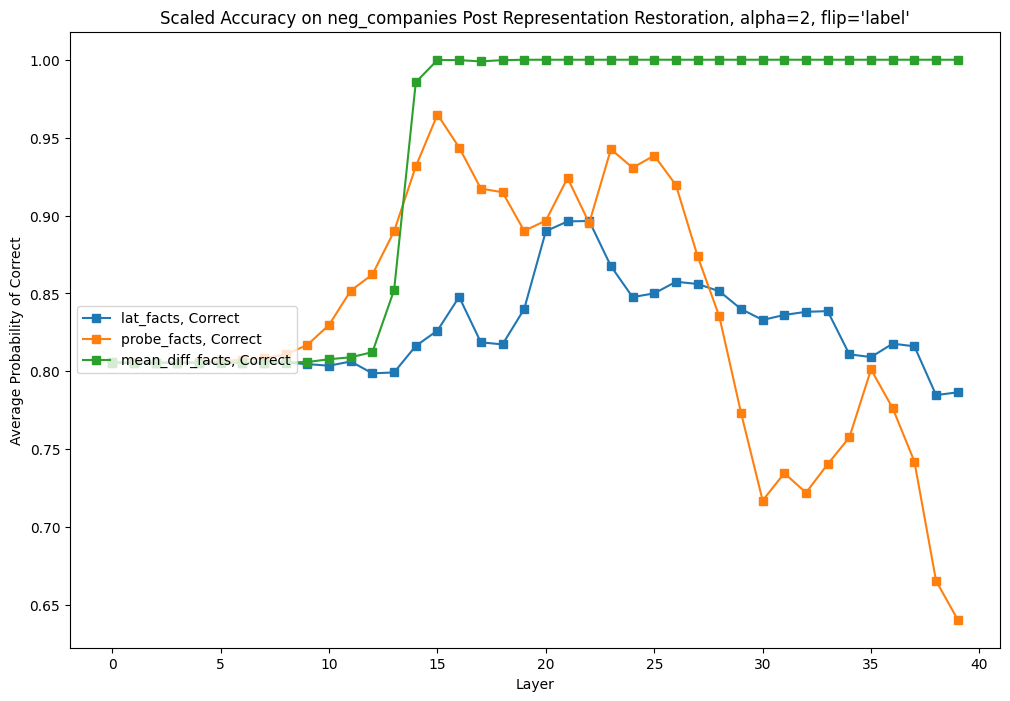

In [30]:
# scale_performance_relative(restored_performances, tuple_index=1)
plot_performances(restored_performances, ["Correct", "Incorrect"], tuple_index=1, title=f"Unscaled Correct and Incorrect Response Rate on {split_name} Post Representation Restoration, {alpha=}, {flip=}", dir_names=["lat_facts", "probe_facts", "mean_diff_facts"])

scale_performance_relative(restored_performances, tuple_index=1)
plot_performances(restored_performances, ["Correct"], tuple_index=1, title=f"Scaled Accuracy on {split_name} Post Representation Restoration, {alpha=}, {flip=}", dir_names=["lat_facts", "probe_facts", "mean_diff_facts"])